In [1]:
# Ignore warnings (primarily for future deprecation warnings)
import warnings
# warnings.filterwarnings('ignore')

# Raster Analysis
import rasterio
import earthpy.plot as ep
from rasterio.merge import merge

# Vector Analysis
from shapely.geometry import box, mapping, Polygon

# General data manipulation
import geopandas as gpd
import pandas as pd
import numpy as np

# Saving and Accessing Data
import os
import pickle
import json

# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
import folium
import seaborn as sns

# Google Earth Engine
import ee
import geemap

# Machine learning

# Keras
import keras
from keras import Sequential
from keras.layers import Conv1D, Dropout, Dense, Input, GlobalMaxPooling1D
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical

c:\Users\juane\miniforge3\envs\TemporalClusterNet\Lib\site-packages\h5py\__init__.py:36: UserWarning: h5py is running against HDF5 1.14.3 when it was built against 1.14.2, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "


In [2]:
import sys
# caution: path[0] is reserved for script path (or '' in REPL)
sys.path.insert(1, os.path.join('src'))

from split_images import split_geometry
import feature_extraction as fe

In [3]:
ee.Authenticate()
ee.Initialize()

In [4]:
'''
We begin by preparing some constant variables that will be used throughout the notebook. 
Note that a seed is set for reproducibility.
'''

SEED = 2024
keras.utils.set_random_seed(SEED)
FEATURES = ['B2', 'B3', 'B4']

In [5]:
def mask_s2_clouds(image):
  """Masks clouds in a Sentinel-2 image using the QA band.

  Args:
      image (ee.Image): A Sentinel-2 image.

  Returns:
      ee.Image: A cloud-masked Sentinel-2 image.
  """
  qa = image.select('QA60')

  # Bits 10 and 11 are clouds and cirrus, respectively.
  cloud_bit_mask = 1 << 10
  cirrus_bit_mask = 1 << 11

  # Both flags should be set to zero, indicating clear conditions.
  mask = (
      qa.bitwiseAnd(cloud_bit_mask)
      .eq(0)
      .And(qa.bitwiseAnd(cirrus_bit_mask).eq(0))
  )

  return image.updateMask(mask).divide(10000)

In [6]:
dataset = (
    ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
    .filterDate('2020-01-01', '2021-01-30')
    # Pre-filter to get less cloudy granules.
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 5))
    .map(mask_s2_clouds)
)

In [7]:
# geometry_sd = ee.Geometry.Polygon(
#     [[[-70.08239177868184,18.412691062890588],
#       [-69.70542339489278,18.412691062890588],
#       [-69.70542339489278,18.610630760258402],
#       [-70.08239177868184,18.610630760258402]]])

geometry_sd = ee.Geometry.Polygon(
    [[[-70.05239177868184,18.422691062890588],
      [-69.75542339489278,18.422691062890588],
      [-69.75542339489278,18.600630760258402],
      [-70.05239177868184,18.600630760258402]]])

sd_cutout = dataset.median().clip(geometry_sd).select(FEATURES)

In [8]:
visualization = {
    'min': 0.0,
    'max': 0.3,
    'bands': ['B4', 'B3', 'B2'],
}

m = geemap.Map()
m.set_center(-69.929611, 18.483402, 12)
m.add_layer(sd_cutout, visualization, 'RGB')
m

Map(center=[18.483402, -69.929611], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=Sea…

In [9]:
# Print dimensions of sd_cutout image
print(sd_cutout.getInfo())

{'type': 'Image', 'bands': [{'id': 'B2', 'data_type': {'type': 'PixelType', 'precision': 'float', 'min': 0, 'max': 6.553500175476074}, 'dimensions': [2, 3], 'origin': [-71, 17], 'crs': 'EPSG:4326', 'crs_transform': [1, 0, 0, 0, 1, 0]}, {'id': 'B3', 'data_type': {'type': 'PixelType', 'precision': 'float', 'min': 0, 'max': 6.553500175476074}, 'dimensions': [2, 3], 'origin': [-71, 17], 'crs': 'EPSG:4326', 'crs_transform': [1, 0, 0, 0, 1, 0]}, {'id': 'B4', 'data_type': {'type': 'PixelType', 'precision': 'float', 'min': 0, 'max': 6.553500175476074}, 'dimensions': [2, 3], 'origin': [-71, 17], 'crs': 'EPSG:4326', 'crs_transform': [1, 0, 0, 0, 1, 0]}], 'properties': {'system:footprint': {'type': 'Polygon', 'coordinates': [[[-70.05239177868184, 18.42269106289059], [-69.75542339489277, 18.42269106289059], [-69.75542339489277, 18.6006307602584], [-70.05239177868184, 18.6006307602584], [-70.05239177868184, 18.42269106289059]]]}}}


In [10]:
# Create a directory for temporary files if it doesn't exist
temp_dir = "temporary"
if not os.path.exists(temp_dir):
    os.makedirs(temp_dir)

output_files = []

output_path = os.path.join(temp_dir, "santo_domingo_img_0.tif")
if not os.path.exists(output_path):

    # Create dataframe to store image coordinates
    image_coords = pd.DataFrame(columns=["file_name", "x", "y"])


    # Split geometry into smaller subregions (to bypass Earth Engine export limit)
    subgeometries = split_geometry(geometry_sd, num_parts=30)

    # Export and download each subregion
    for i, subgeometry in enumerate(subgeometries):
        output_filename = os.path.join(temp_dir, f"santo_domingo_img_{i}.tif")
        # Convert Shapely geometry to GeoJSON
        geojson_geometry = json.dumps(mapping(subgeometry))
        task = geemap.ee_export_image(sd_cutout, filename=output_filename, region=geojson_geometry, scale=1)
        print(f"Exporting {output_filename}...")

        new_row = pd.DataFrame([{"file_name": output_filename, "x": subgeometry.centroid.x, "y": subgeometry.centroid.y}])

        # Concatenate the new row to the existing DataFrame
        image_coords = pd.concat([image_coords, new_row], ignore_index=True)

    # Read and merge downloaded images
    output_files = [os.path.join(temp_dir, f"santo_domingo_img_{i}.tif") for i in range(len(subgeometries))]
else:
    print("Found existing santo_domingo_img_#.tif file. Using that instead.")

Found existing santo_domingo_img_#.tif file. Using that instead.


In [11]:
from keras.preprocessing import image

In [12]:
from keras.applications.vgg16 import VGG16 as vgg
from keras.applications.vgg16 import preprocess_input as vgg_p

In [13]:
from tensorflow.keras.applications import EfficientNetB7 as effnet
from tensorflow.keras.applications.efficientnet import preprocess_input as effnet_p

In [14]:
image_list = []

for img_path in os.listdir("temporary"):
    print(img_path)
    with rasterio.open(os.path.join("temporary", img_path)) as src:

        img = src.read([1, 2, 3])  # Read the first three channels (RGB)
        img = np.transpose(img, (1, 2, 0))  # Transpose to (height, width, channels)
        
        # Normalize to 0-255 and convert to uint8
        img = (img - img.min()) / (img.max() - img.min()) * 255
        img = img.astype(np.uint8)

        # Convert to Pillow image
        pil_img = image.array_to_img(img, scale=False)
        pil_img = pil_img.resize((1103, 662))  # Resize the image to the desired size
        
        image_list.append(pil_img)

santo_domingo_img_0.tif
santo_domingo_img_1.tif
santo_domingo_img_10.tif
santo_domingo_img_100.tif
santo_domingo_img_101.tif
santo_domingo_img_102.tif
santo_domingo_img_103.tif
santo_domingo_img_104.tif
santo_domingo_img_105.tif
santo_domingo_img_106.tif
santo_domingo_img_107.tif
santo_domingo_img_108.tif
santo_domingo_img_109.tif
santo_domingo_img_11.tif
santo_domingo_img_110.tif
santo_domingo_img_111.tif
santo_domingo_img_112.tif
santo_domingo_img_113.tif
santo_domingo_img_114.tif
santo_domingo_img_115.tif
santo_domingo_img_116.tif
santo_domingo_img_117.tif
santo_domingo_img_118.tif
santo_domingo_img_119.tif
santo_domingo_img_12.tif
santo_domingo_img_120.tif
santo_domingo_img_121.tif
santo_domingo_img_122.tif
santo_domingo_img_123.tif
santo_domingo_img_124.tif
santo_domingo_img_125.tif
santo_domingo_img_126.tif
santo_domingo_img_127.tif
santo_domingo_img_128.tif
santo_domingo_img_129.tif
santo_domingo_img_13.tif
santo_domingo_img_130.tif
santo_domingo_img_131.tif
santo_domingo_img_13

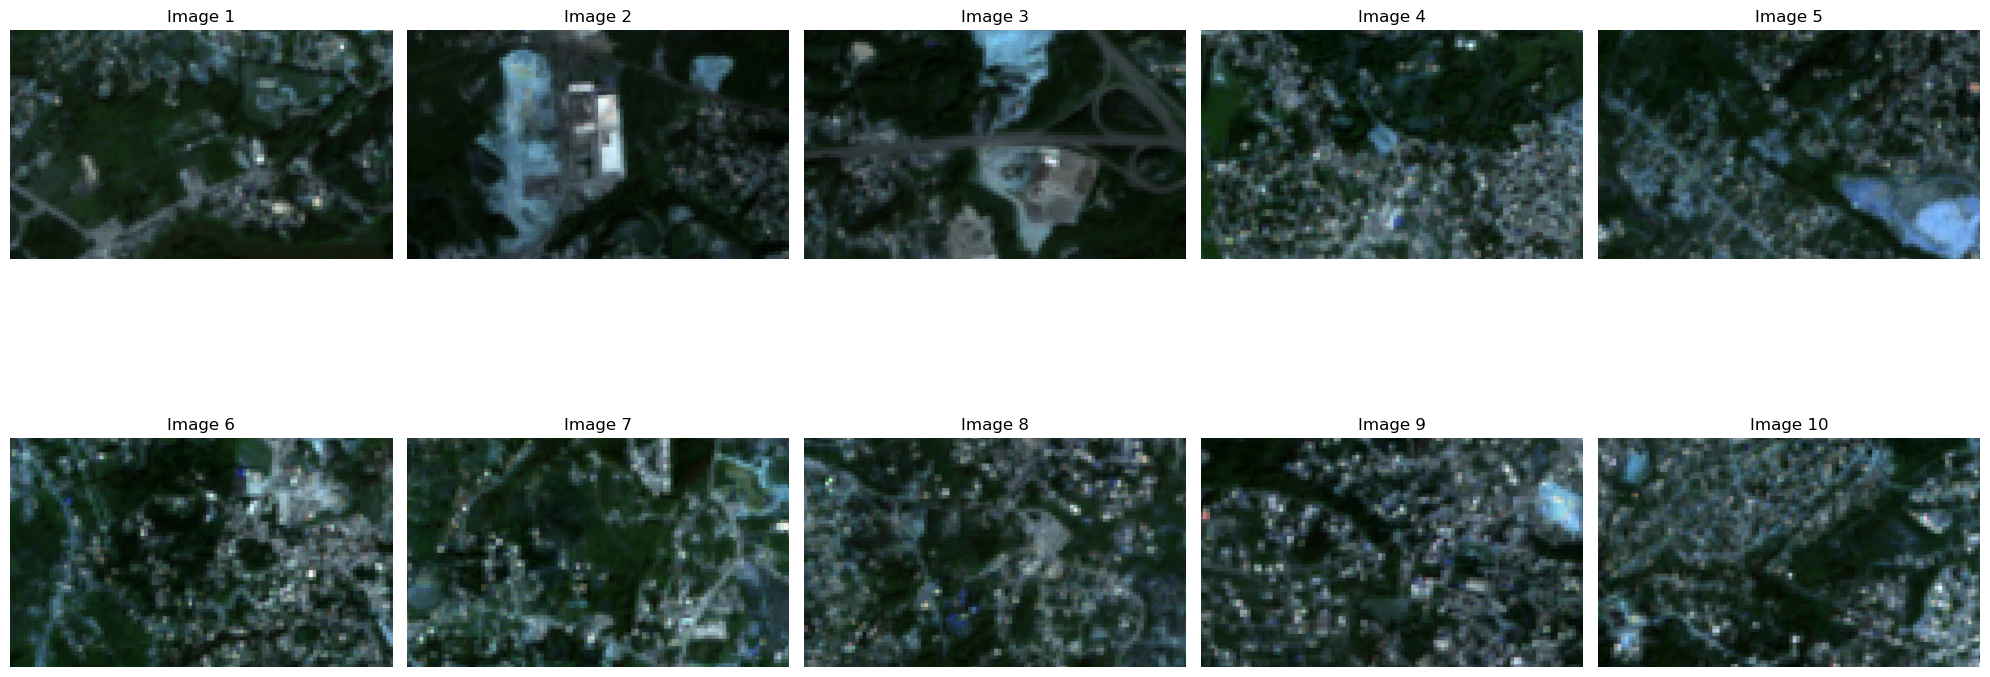

In [15]:
# Show the images in image_list_testing
fig, axes = plt.subplots(2, 5, figsize=(20, 10))
for i, ax in enumerate(axes.flat):
    ax.imshow(image_list[i-1])
    ax.axis("off")
    ax.set_title(f"Image {i+1}")

plt.tight_layout()
plt.show()

In [16]:
df_effnet_features = fe.extract(effnet, effnet_p, image_list, (662, 1103, 3))

29/29 ━━━━━━━━━━━━━━━━━━━━ 8043s 273s/step


In [17]:
# Save df_features to a csv file
df_effnet_features.to_csv(os.path.join("output", "img_effnet7_features.csv"), index=True)

In [52]:
df_effnet_features.shape

(900, 2560)

In [53]:
df_effnet_features.head(10)

,0,1,2,3,4,5,6,7,8,9,...,2550,2551,2552,2553,2554,2555,2556,2557,2558,2559
0,0.202694,-0.081792,-0.227756,0.155381,-0.066303,0.002430,0.035001,0.128959,0.131514,-0.164019,...,0.102956,-0.033326,-0.206493,0.235746,-0.083914,-0.018846,-0.127156,-0.037394,0.006842,-0.018068
1,0.037100,-0.020237,-0.213950,0.112765,-0.156208,-0.039857,0.077102,0.010710,-0.031621,-0.157502,...,0.249663,-0.095952,-0.192630,0.116444,0.015505,-0.070586,-0.194139,-0.112880,-0.052699,0.020254
2,0.109109,-0.172439,-0.231494,0.057703,-0.164295,-0.040664,-0.061876,-0.019940,-0.014259,-0.162000,...,0.024788,-0.050463,-0.183824,0.251548,-0.035079,-0.157421,-0.171556,-0.035112,-0.070191,-0.162780
3,0.041409,-0.185916,-0.217001,-0.012261,-0.168160,-0.092132,-0.053870,-0.079329,-0.109836,-0.177992,...,-0.010581,-0.161669,-0.183999,0.187722,-0.030637,-0.170584,-0.192873,-0.070221,-0.106276,-0.195337
4,0.060620,-0.194082,-0.217579,-0.067940,-0.166668,-0.115366,-0.037999,-0.117710,-0.101637,-0.195789,...,-0.024120,-0.124708,-0.169687,0.267371,-0.026533,-0.185577,-0.178434,-0.091514,-0.116363,-0.211351
5,-0.016897,-0.185143,-0.202755,-0.084915,-0.157805,-0.124236,-0.010070,-0.074056,-0.077459,-0.177790,...,-0.021175,-0.129078,-0.150748,0.119138,-0.036412,-0.157899,-0.181190,-0.108804,-0.092638,-0.188304
6,0.045892,-0.204745,-0.218579,-0.090543,-0.154940,-0.114324,-0.000402,-0.108396,-0.103337,-0.187470,...,-0.024018,-0.157432,-0.168516,0.215469,-0.011816,-0.177535,-0.167003,-0.084924,-0.112298,-0.204882
7,-0.037340,-0.219596,-0.214401,-0.091312,-0.171417,-0.132528,0.020134,-0.084107,-0.137452,-0.161415,...,-0.022609,-0.157213,-0.135124,0.128742,-0.036155,-0.198045,-0.180229,-0.074238,-0.103988,-0.192159
8,0.008474,-0.160904,-0.210314,-0.055348,-0.158117,-0.086925,-0.023249,-0.055427,-0.117473,-0.186271,...,-0.050555,-0.168642,-0.164257,0.223622,-0.041020,-0.177900,-0.190913,-0.024267,-0.087423,-0.186487
9,0.225928,-0.212366,-0.231926,-0.015924,-0.147499,0.008213,-0.012783,-0.098941,-0.035582,-0.205686,...,-0.073883,-0.127068,-0.174310,0.250908,-0.046442,-0.188797,-0.186706,-0.009076,-0.054113,-0.171229


In [55]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [86]:
scaler = StandardScaler()
df_effnet_features_pca = scaler.fit_transform(df_effnet_features)

In [78]:
# Use PCA to reduce the dimensionality of the features
pca = PCA(random_state=SEED)
pca.fit(df_effnet_features_pca)

PCA(random_state=2024)

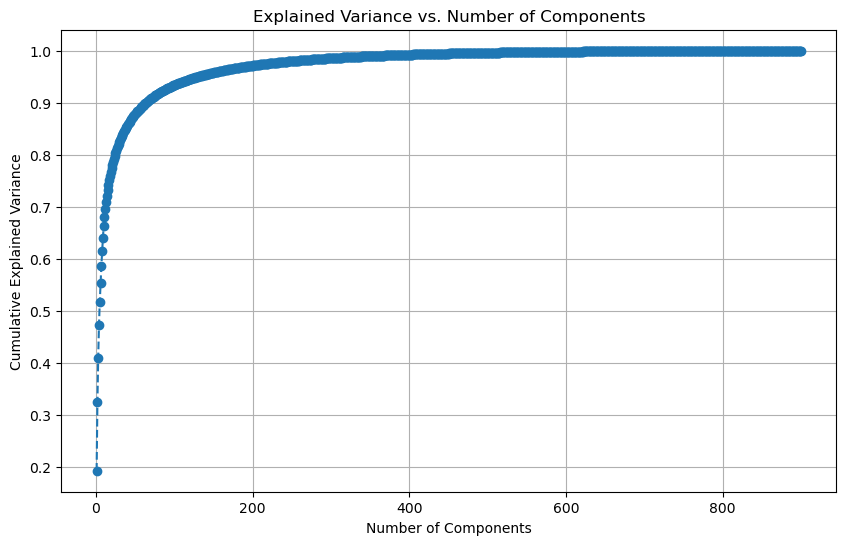

In [79]:
# Plot the cumulative explained variance
cumulative_explained_variance = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o', linestyle='--')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs. Number of Components')
plt.grid(True)
plt.show()

In [80]:
# For example, if you want to retain 95% of the variance
n_components = np.argmax(cumulative_explained_variance >= 0.95) + 1
print(f'Number of components to retain 95% variance: {n_components}')

Number of components to retain 95% variance: 130


In [87]:
pca = PCA(n_components=2, random_state=SEED)
pca.fit(df_effnet_features_pca)

PCA(n_components=2, random_state=2024)

In [89]:
# Transform the features
df_effnet_features_pca = pd.DataFrame(pca.transform(df_effnet_features_pca), index=df_effnet_features.index)

In [90]:
df_effnet_features_pca

,0,1
0,24.364998,18.205107
1,34.466209,20.370699
2,12.057902,-9.799787
3,-1.321845,-21.274038
4,-2.368639,-25.444675
...,...,...
895,12.024047,-6.981150
896,11.048113,5.037847
897,17.098591,11.099235
898,16.523987,16.640255


In [91]:
# Add the image_list items to the DataFrame (line them up)
df_effnet_features_pca["image"] = image_list

In [92]:
# Get the color average of each image
df_effnet_features_pca["color_avg"] = df_effnet_features_pca["image"].apply(lambda x: np.mean(x, axis=(0, 1)))
# Convert the RGB lists to a format suitable for Matplotlib
df_effnet_features_pca['color_avg'] = df_effnet_features_pca['color_avg'].apply(lambda x: [c/255 for c in x])


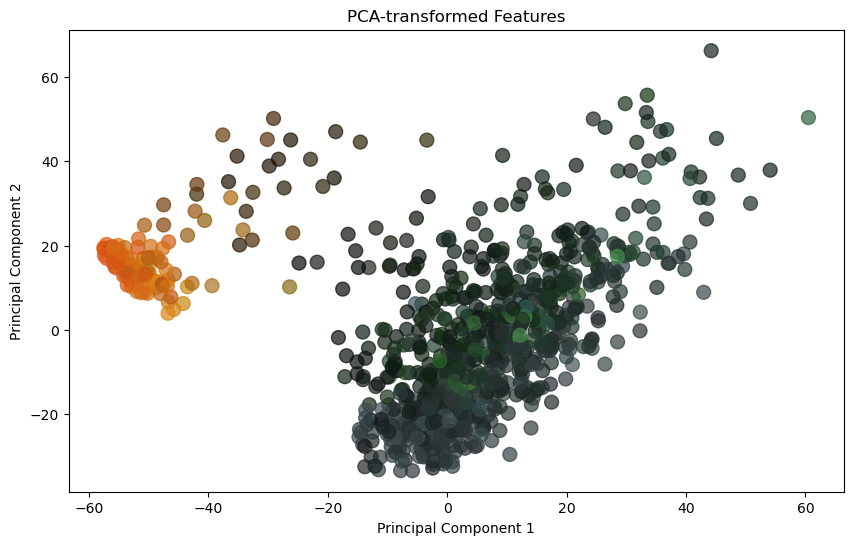

In [93]:
plt.figure(figsize=(10, 6))
plt.scatter(
    x=df_effnet_features_pca[0], 
    y=df_effnet_features_pca[1], 
    c=df_effnet_features_pca['color_avg'].tolist(), 
    s=100, 
    edgecolor=None, 
    alpha=0.7
)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA-transformed Features")
plt.show()


In [94]:
effnet_features_pca_130 = scaler.fit_transform(df_effnet_features)

In [95]:
pca = PCA(n_components=130, random_state=SEED)
pca.fit(effnet_features_pca_130)
effnet_features_pca_130 = pd.DataFrame(pca.transform(effnet_features_pca_130), index=df_effnet_features.index)

In [97]:
# Cluster the features using KMeans
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=50, random_state=SEED)
effnet_features_pca_130["cluster"] = kmeans.fit_predict(effnet_features_pca_130)

In [98]:
effnet_features_pca_130

,0,1,2,3,4,5,6,7,8,9,...,121,122,123,124,125,126,127,128,129,cluster
0,24.365015,18.205099,-2.842037,-10.919543,-7.817112,-3.393263,-14.525891,-2.030805,3.398234,-15.137774,...,1.797421,0.017897,0.701563,-2.500930,2.121923,1.813484,0.352562,-1.071780,0.054056,29
1,34.466225,20.370678,-9.559703,-17.328117,-8.668034,9.376010,13.981024,3.031681,6.932229,-17.025156,...,1.336879,-2.370495,-0.880626,1.710001,0.239875,-0.324290,-1.904006,1.686009,-0.279801,11
2,12.057906,-9.799797,-4.530878,9.734324,-2.389880,-1.038636,-7.772033,-7.809720,0.151811,-6.229351,...,0.620913,0.691050,-0.090501,-0.152619,-0.635914,0.860417,1.479579,0.104586,-0.357050,42
3,-1.321849,-21.274065,-21.195860,-11.777366,-11.560336,4.941218,12.198281,-5.684247,-0.318651,3.971622,...,0.446857,0.343116,0.703562,-0.082700,1.414027,0.170352,-0.073961,-0.588228,0.845573,1
4,-2.368645,-25.444698,-12.894086,-5.547476,-14.229286,3.172915,7.695414,-7.033743,-2.092196,-1.591666,...,0.074939,0.013746,0.123127,0.174362,0.610449,0.266900,0.151637,-0.375138,0.326927,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
895,12.024051,-6.981186,-21.853224,-7.739038,-23.055119,0.863830,0.174898,-1.692043,6.724401,-3.376520,...,1.211530,-1.250373,0.731426,1.597611,2.102839,-0.145879,-0.326802,-1.506672,-0.365094,6
896,11.048121,5.037817,-19.476353,-2.808257,-6.980496,1.696853,3.907358,5.694927,5.473085,-8.737864,...,-0.553121,-0.391952,-1.304142,0.936150,-1.251190,1.799403,0.351748,0.111591,1.870454,6
897,17.098604,11.099216,-11.256565,-0.399570,10.011578,-6.378978,0.774247,6.076526,-9.094777,12.497933,...,1.918959,-0.997245,-0.691120,0.844894,-0.729045,1.469068,2.737172,-0.311823,0.474611,15
898,16.523996,16.640228,-14.430265,-3.006162,6.630214,-2.195045,-0.420226,8.106909,-11.759322,7.571549,...,1.846435,-0.970270,-0.606344,-1.252962,0.291351,0.457484,-0.731904,-1.575704,0.154247,15


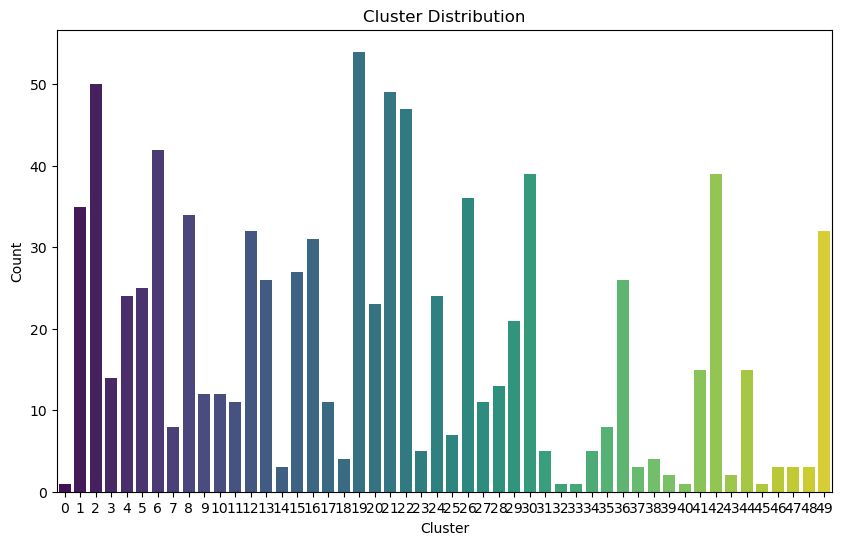

In [99]:
# What is the distribution of clusters?
cluster_counts = effnet_features_pca_130["cluster"].value_counts().sort_index()

plt.figure(figsize=(10, 6))
sns.barplot(x=cluster_counts.index, y=cluster_counts.values, palette='viridis')
plt.xlabel("Cluster")
plt.ylabel("Count")
plt.title("Cluster Distribution")
plt.show()

In [100]:
effnet_features_pca_130["image"] = image_list

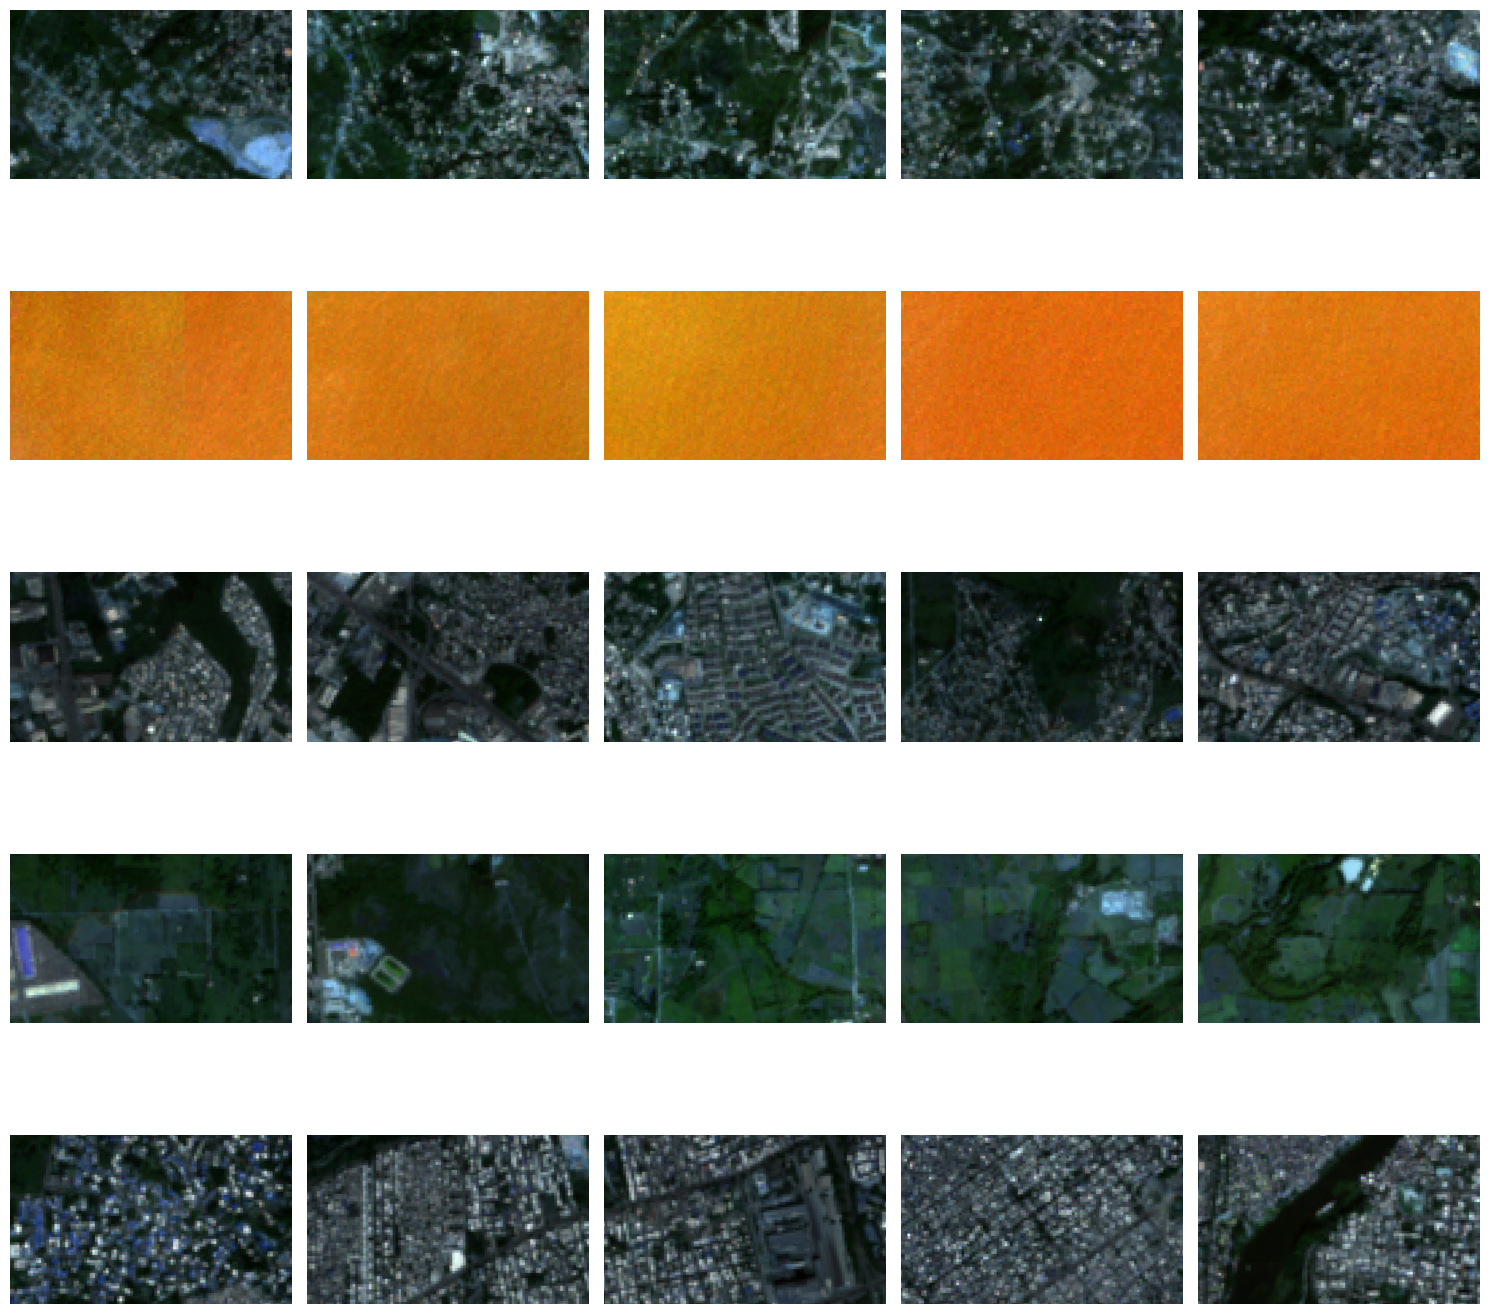

In [104]:

# Filter 5 images for each cluster from 1 to 5
start_cluster = 1
end_cluster = 5
num_images_per_cluster = 5

# Create a plot with 5x5 subplots
fig, axes = plt.subplots(end_cluster - start_cluster + 1, num_images_per_cluster, figsize=(15, 15))

for cluster in range(start_cluster, end_cluster + 1):
    cluster_images = effnet_features_pca_130[effnet_features_pca_130['cluster'] == cluster]['image'].head(num_images_per_cluster)
    for i, img in enumerate(cluster_images):
        axes[cluster - start_cluster, i].imshow(img)
        axes[cluster - start_cluster, i].axis('off')  # Hide axes for a cleaner look

# Adjust layout to avoid overlapping
plt.tight_layout()
plt.show()

In [105]:
effnet_features_pca_130.head()

,0,1,2,3,4,5,6,7,8,9,...,122,123,124,125,126,127,128,129,cluster,image
0,24.365015,18.205099,-2.842037,-10.919543,-7.817112,-3.393263,-14.525891,-2.030805,3.398234,-15.137774,...,0.017897,0.701563,-2.500930,2.121923,1.813484,0.352562,-1.071780,0.054056,29,<PIL.Image.Image image mode=RGB size=1103x662 ...
1,34.466225,20.370678,-9.559703,-17.328117,-8.668034,9.376010,13.981024,3.031681,6.932229,-17.025156,...,-2.370495,-0.880626,1.710001,0.239875,-0.324290,-1.904006,1.686009,-0.279801,11,<PIL.Image.Image image mode=RGB size=1103x662 ...
2,12.057906,-9.799797,-4.530878,9.734324,-2.389880,-1.038636,-7.772033,-7.809720,0.151811,-6.229351,...,0.691050,-0.090501,-0.152619,-0.635914,0.860417,1.479579,0.104586,-0.357050,42,<PIL.Image.Image image mode=RGB size=1103x662 ...
3,-1.321849,-21.274065,-21.195860,-11.777366,-11.560336,4.941218,12.198281,-5.684247,-0.318651,3.971622,...,0.343116,0.703562,-0.082700,1.414027,0.170352,-0.073961,-0.588228,0.845573,1,<PIL.Image.Image image mode=RGB size=1103x662 ...
4,-2.368645,-25.444698,-12.894086,-5.547476,-14.229286,3.172915,7.695414,-7.033743,-2.092196,-1.591666,...,0.013746,0.123127,0.174362,0.610449,0.266900,0.151637,-0.375138,0.326927,1,<PIL.Image.Image image mode=RGB size=1103x662 ...
